In [276]:
import mvts_utils as mv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [243]:
num_samples_list = np.array([5, 6, 7, 8, 9, 10, 15, 20, 50, 100])
noise_list = np.array([0,.05,.1,.25,.5,.75,1,2.5,5,7.5,10])
times = np.arange(0,1000,.1)
n_splits = 1000

lr = LogisticRegression(max_iter=10000, random_state=37)
svm = SVC(random_state=37)
xgb = XGBClassifier(random_state=37)
classifiers = {'Logistic Regression': lr, 'SVM': svm, 'XGBoost': xgb}

acc = np.empty((len(num_samples_list),len(noise_list),n_splits)) 
acc_df = pd.DataFrame()

for inoise,noise in enumerate(noise_list):
    print(f'Noise level: {noise}')

    x, y = mv.make_prepared_dataset(times, noise=noise)

    for clf_name, clf in classifiers.items():

        for isamp,num_samples in enumerate(num_samples_list):

            clf_pipeline = make_pipeline(StandardScaler(), clf)
            shuffle = mv.DownsampleStratifiedShuffleSplit(n_splits=n_splits,test_size=.2,num_samples=num_samples)

            scores = cross_val_score(clf_pipeline, x, y, cv=shuffle)
            acc[isamp, inoise] = scores
            acc_df = acc_df.append({'Accuracy': np.mean(scores), 'Classifier': clf_name, 'Noise': noise, 'Number of training samples': int(num_samples)}, ignore_index=True)


Noise level: 0.0
Noise level: 0.05
Noise level: 0.1
Noise level: 0.25
Noise level: 0.5
Noise level: 0.75
Noise level: 1.0
Noise level: 2.5
Noise level: 5.0
Noise level: 7.5
Noise level: 10.0


In [268]:
acc_df['Number of training samples'] = acc_df['Number of training samples'].astype(int)

In [277]:

acc_lr = acc_df.query('Classifier=="Logistic Regression"').pivot('Number of training samples', 'Noise', 'Accuracy')
acc_svm = acc_df.query('Classifier=="SVM"').pivot('Number of training samples', 'Noise', 'Accuracy')
acc_xgb = acc_df.query('Classifier=="XGBoost"').pivot('Number of training samples', 'Noise', 'Accuracy')


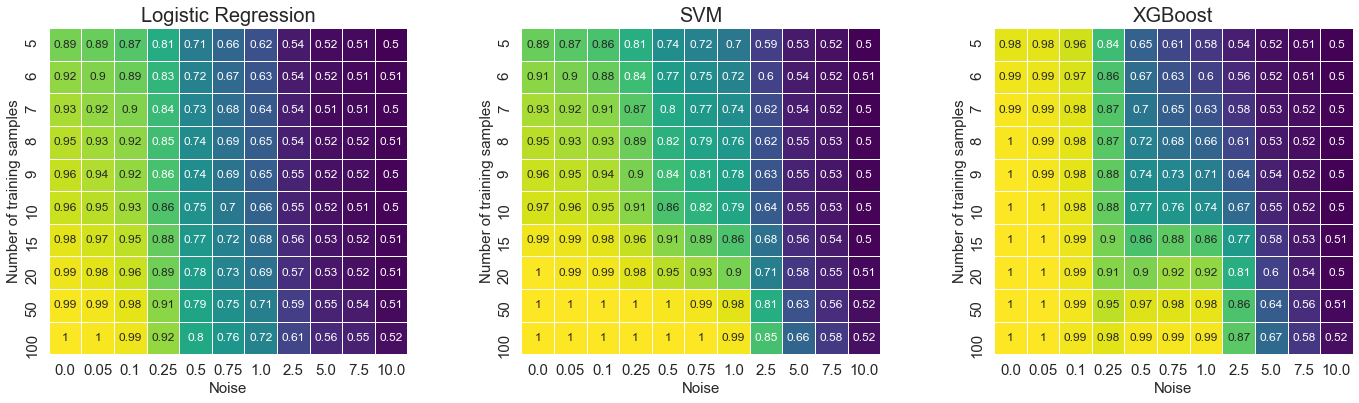

In [287]:
fig, axes = plt.subplots(1,3,figsize=(24,6))
sns.heatmap(acc_lr, annot=True, vmin=.5, vmax=1, cmap='viridis', square=True,linewidths=1,ax=axes[0],cbar=False)
sns.heatmap(acc_svm, annot=True, vmin=.5, vmax=1, cmap='viridis', square=True,linewidths=1,ax=axes[1],cbar=False)
sns.heatmap(acc_xgb, annot=True, vmin=.5, vmax=1, cmap='viridis', square=True,linewidths=1,ax=axes[2],cbar=False)

for ax,title in zip(axes,classifiers.keys()):
    ax.set_title(title,fontsize=20)
    ax.tick_params(labelsize=15)
    ax.set_xlabel('Noise',fontsize=15)
    ax.set_ylabel('Number of training samples',fontsize=15)
